In [1]:
#checking we are working on the right virtual environment

In [2]:
import sys
sys.executable
#!pip3 freeze > requirements.txt
#!python --version

'/Users/federicojacopobaldoni/Documents/LUISS/machine_learning/pino_env/bin/python3'

In [3]:
#importing packages

In [4]:
import numpy as np
import pandas as pd

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import spearmanr

# EDA

importing dataset

In [5]:
df = pd.read_csv('./Project datasets-20230327/flight_dataset.csv', index_col=0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


resetting index, just to be sure

In [6]:
df.reset_index(inplace=True)

In [7]:
#profile = ProfileReport(df, title="FLIGHTS - Pandas Profiling Report", explorative=True)
#profile.to_file("flights.html")

checking for nans

In [8]:
df.isna().sum()

index               0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

checking for duplicates

In [9]:
df.duplicated().sum()

0

In [10]:
########
########

## PRICE

looking at price distribution

Text(0.5, 1.0, 'PRICE HISTOGRAM')

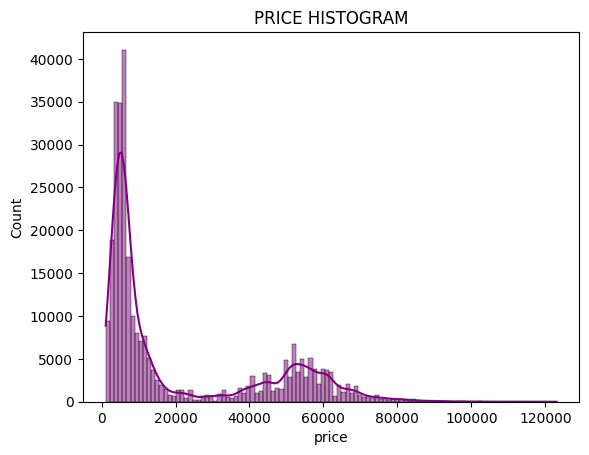

In [11]:
sns.histplot(data=df, x='price', kde=True, color='purple')
plt.title('PRICE HISTOGRAM')

price seems to be pretty skewed

we'll probably have to work on it later

In [12]:
#########
########

### CITIES

price boxplots on source and destionation cities

[Text(0.5, 1.0, 'BOXPLOT PRICE - DESTINATION CITY')]

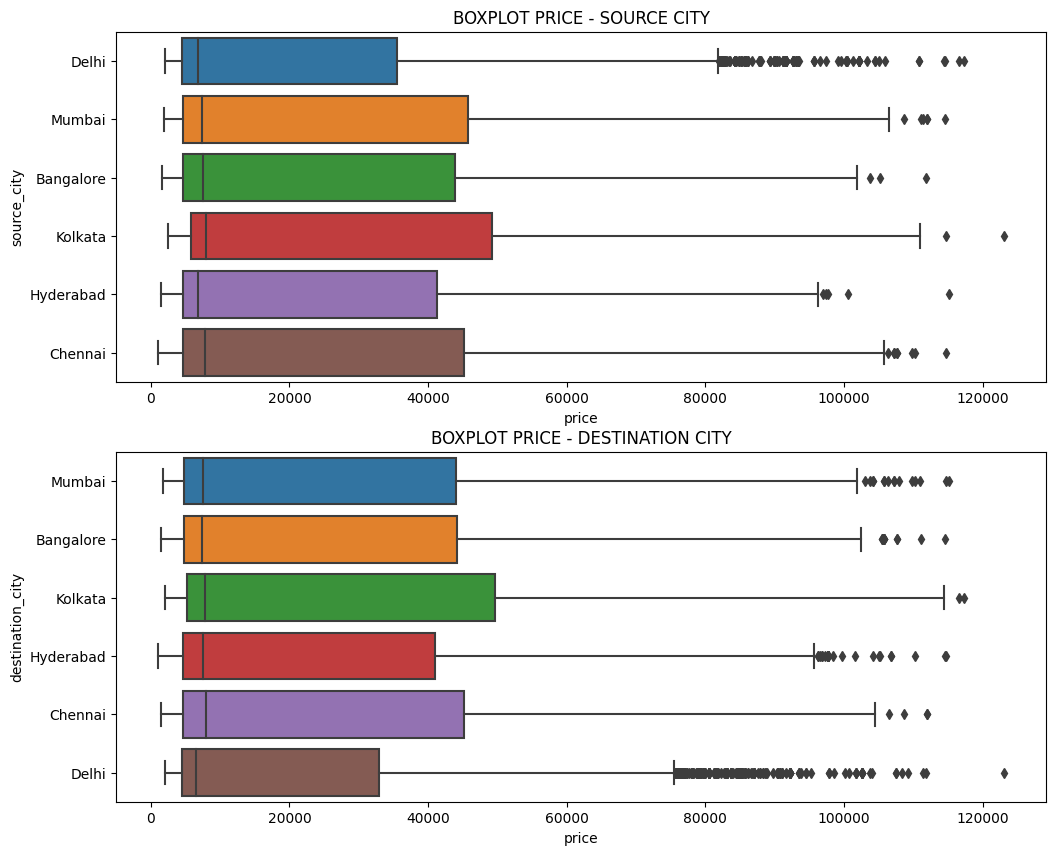

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

g1 = sns.boxplot(data=df, x='price', y='source_city', ax=axs[0])
g1.set(title = 'BOXPLOT PRICE - SOURCE CITY')

g2 = sns.boxplot(data=df, x='price', y='destination_city', ax=axs[1])
g2.set(title = 'BOXPLOT PRICE - DESTINATION CITY')

In [14]:
city_cross = pd.crosstab(df['source_city'], df['destination_city'])
city_cross

destination_city,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
source_city,,,,,,
Bangalore,0,6410,13756,8928,10028,12939
Chennai,6493,0,9783,6103,6983,9338
Delhi,14012,10780,0,9328,11934,15289
Hyderabad,7854,6395,8506,0,7987,10064
Kolkata,9824,6653,10506,7897,0,11467
Mumbai,12885,10130,14809,10470,12602,0


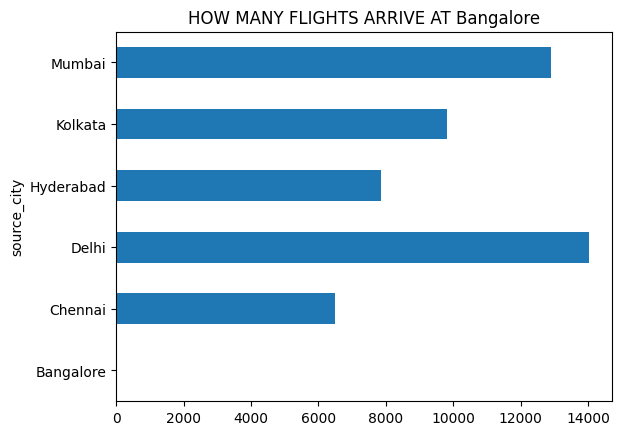

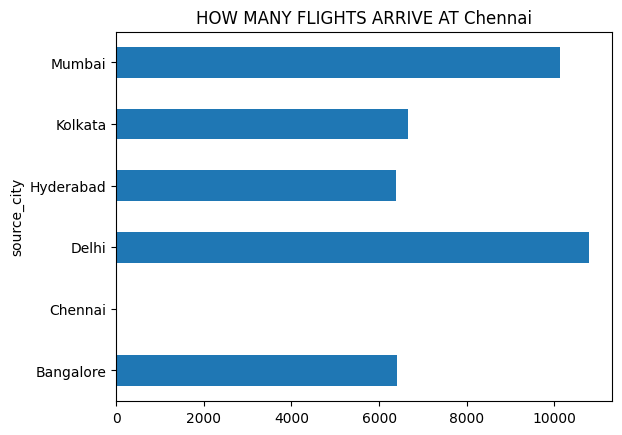

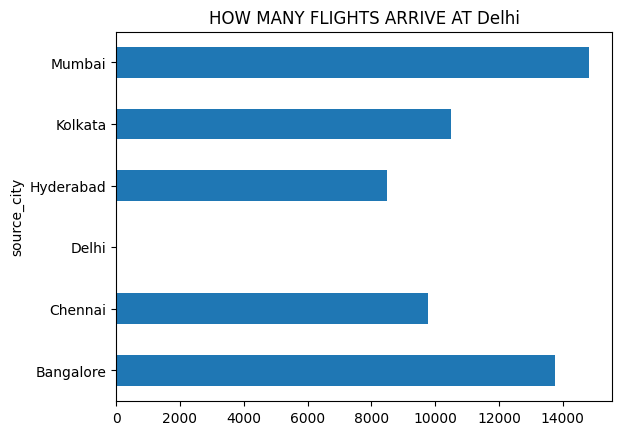

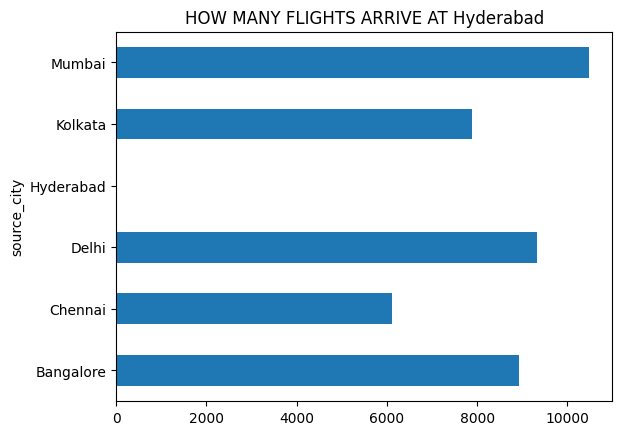

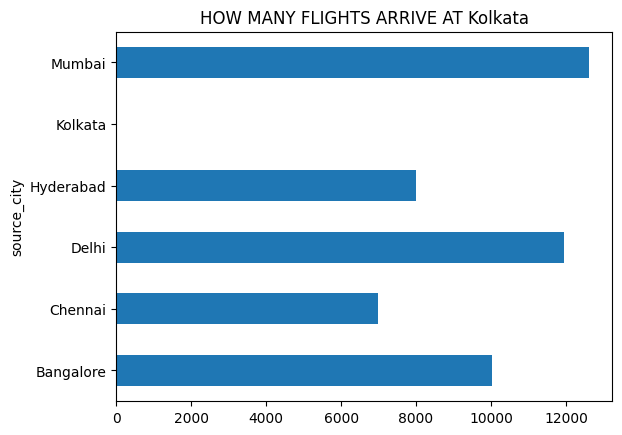

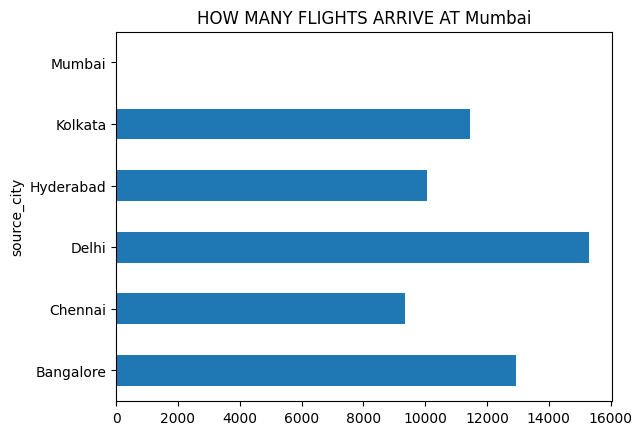

In [15]:
for i in city_cross.columns:
    city_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS ARRIVE AT {i}')
    plt.show()

In [16]:
########
########

### STOPS

price boxplots on the number of stops made

Text(0.5, 1.0, 'BOXPLOT PRICE - STOPS')

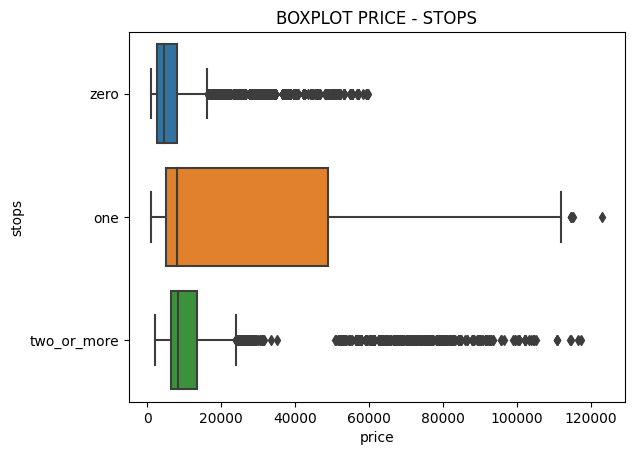

In [17]:
sns.boxplot(data=df, x='price', y='stops')
plt.title('BOXPLOT PRICE - STOPS')

interestingly zero stops flights tend to be the more economic ones, this may be due to the fact that they make smaller voyages


two or more stops have a lot of outliers, may that be last minute flights?

In [18]:
stops_cross = pd.crosstab(df['destination_city'], df['stops'])
stops_cross

stops,one,two_or_more,zero
destination_city,,,
Bangalore,42516,2674,5878
Chennai,33316,3239,3813
Delhi,46536,785,10039
Hyderabad,36578,2064,4084
Kolkata,42177,3195,4162
Mumbai,49740,1329,8028


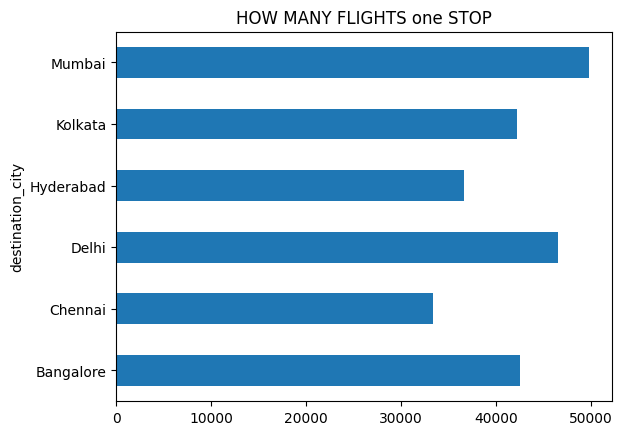

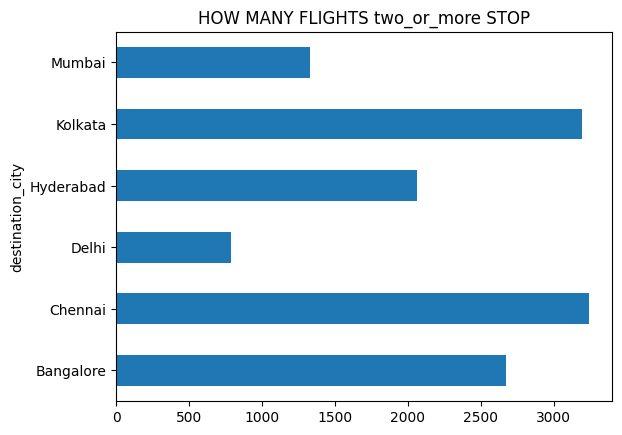

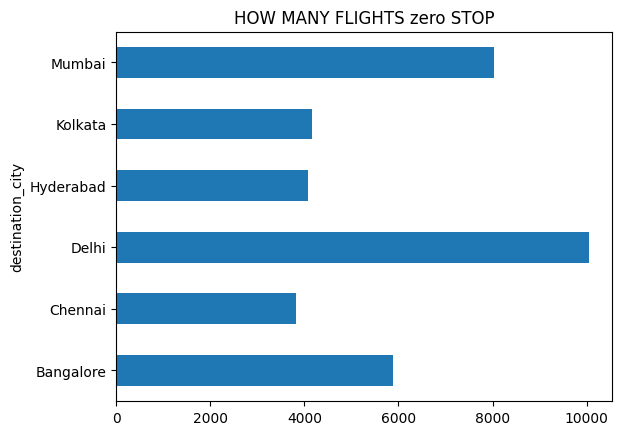

In [19]:
for i in stops_cross.columns:
    stops_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS {i} STOP')
    plt.show()

Dheli doen't work a lot with two or more stops flights, but works a lot more than the others with zero stop fligths

In [20]:
#########
#########

### ARRIVAL TIME

price boxplots on the arrival time

Text(0.5, 1.0, 'BOXPLOT PRICE - ARRIVAL TIME')

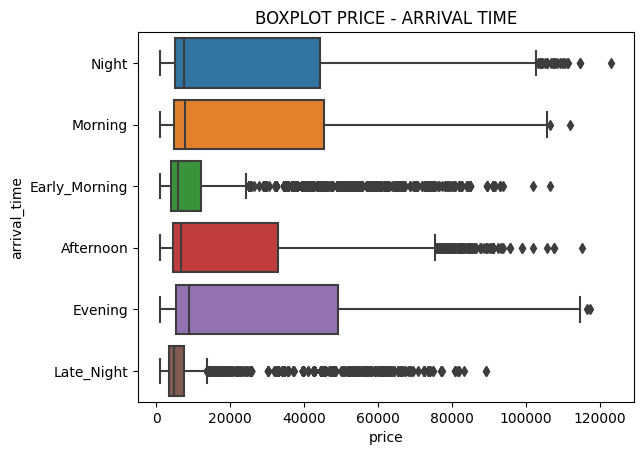

In [21]:
sns.boxplot(data=df, x='price', y='arrival_time')
plt.title('BOXPLOT PRICE - ARRIVAL TIME')

as expected the most economic flights are the one that arrive at destination in the late night or early in the morining

also afternoon flights is reasonable that are a little cheaper than the reaming arrival time

In [22]:
arr_cross = pd.crosstab(df['destination_city'], df['arrival_time'])
arr_cross

arrival_time,Afternoon,Early_Morning,Evening,Late_Night,Morning,Night
destination_city,,,,,,
Bangalore,4827,1823,13937,3176,11246,16059
Chennai,2731,3481,9318,975,10680,13183
Delhi,10206,536,13940,6296,10338,16044
Hyderabad,6318,3822,10498,555,7511,14022
Kolkata,5540,2377,17917,1230,11982,10488
Mumbai,8517,3378,12713,1769,10978,21742


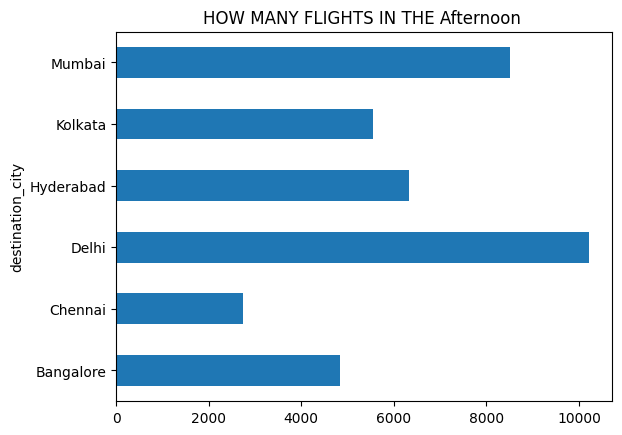

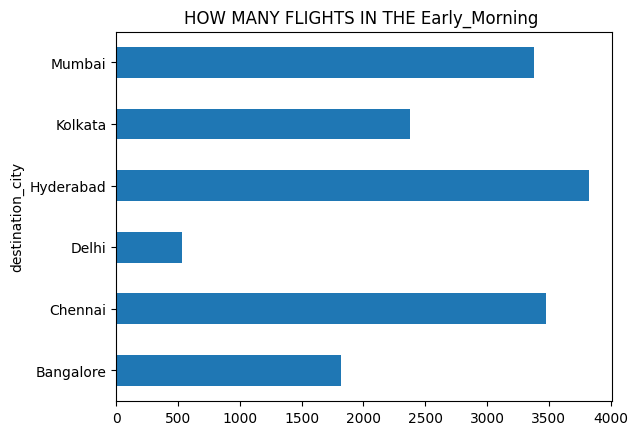

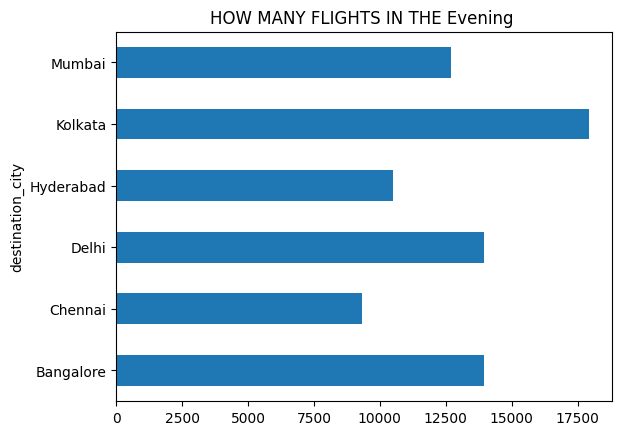

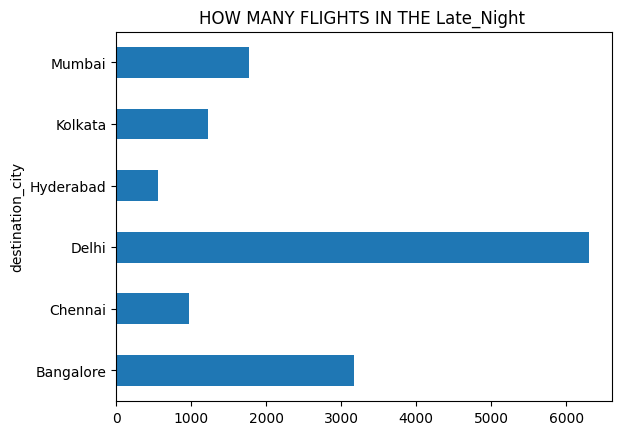

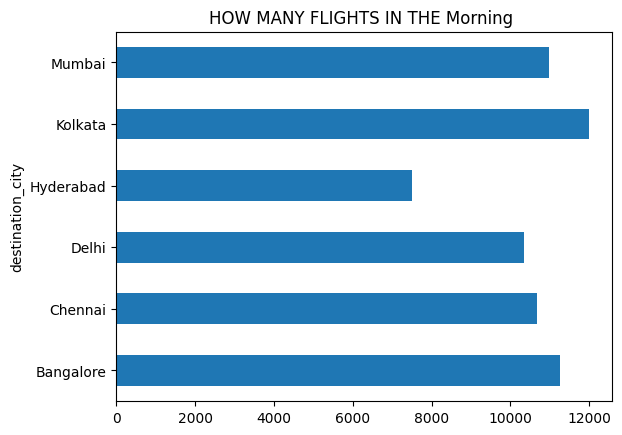

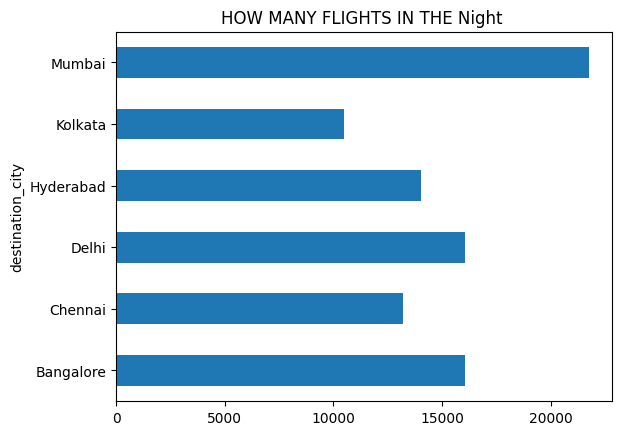

In [23]:
for i in arr_cross.columns:
    arr_cross[f'{i}'].plot(kind='barh')
    #plt.grid()
    plt.title(f'HOW MANY FLIGHTS IN THE {i} ')
    plt.show()

it's interesting to notice that Dheli seems to work a lot in the Late_Night, but pretty much nothing in the Early_Morning

In [24]:
########
########

### CLASS

price boxplots on class

Text(0.5, 1.0, 'BOXPLOT PRICE - CLASS')

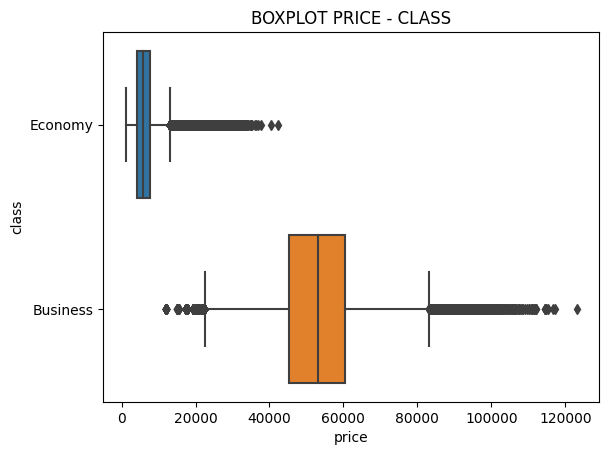

In [25]:
sns.boxplot(data=df, x='price', y='class')
plt.title('BOXPLOT PRICE - CLASS')

well.. as exepcted economy flights are cheaper

In [26]:
########
########

### DURATION

price - duration scatterplot

Text(0.5, 1.0, 'SCATTERPLOT PRICE - DURATION')

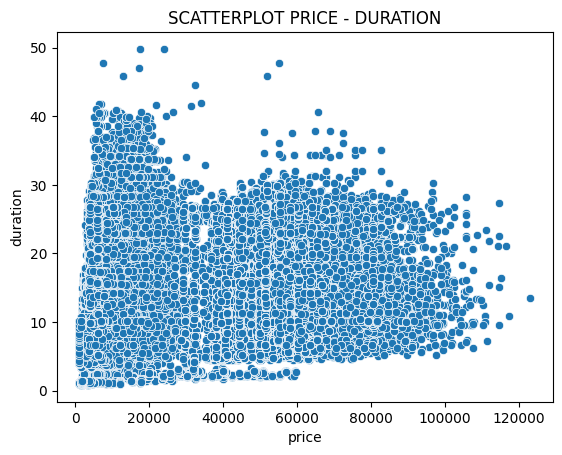

In [27]:
sns.scatterplot(data=df, x='price', y='duration')
plt.title('SCATTERPLOT PRICE - DURATION')

paradoxaly longer duration flights are not the more expensive

In [28]:
#########
#########

## CORRELATION

correlation matrix

/var/folders/fm/x5zqnyj163g5fgggdb9tcnbc0000gn/T/ipykernel_5249/3656167835.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm")


<AxesSubplot: >

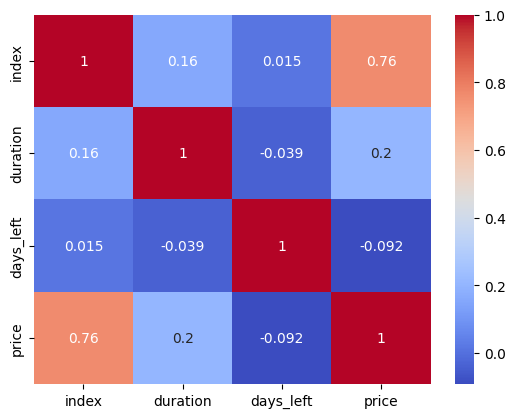

In [29]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

Spearman correlation coefficient for categorical variables

In [30]:
df_cat = df.copy()
for i in df_cat.columns:
    if df_cat[i].dtypes == 'int64' or df_cat[i].dtypes == 'float64':       
           df_cat = df_cat.drop(i, axis=1)
            
for i in df_cat.columns:
    df_cat[i] = df_cat[i].astype('category')

print('Spearman correlation coefficient: \n')
for col1, col2 in combinations(df_cat.columns, 2):
    correlation, p_value = spearmanr(df_cat[col1].cat.codes, df_cat[col2].cat.codes)
    print(col1, '-', col2, ': ', correlation)

Spearman correlation coefficient: 

airline - flight :  0.7034151104009911
airline - source_city :  -0.02735238546003054
airline - departure_time :  0.05421849551088196
airline - stops :  -0.03891205058598072
airline - arrival_time :  0.0355373013881484
airline - destination_city :  -0.0298873183638078
airline - class :  -0.18756793050928966
flight - source_city :  0.026230830567236466
flight - departure_time :  0.07594613693939253
flight - stops :  -0.09626058154289178
flight - arrival_time :  0.04591479336881819
flight - destination_city :  -0.06203597994143653
flight - class :  -0.252726492158629
source_city - departure_time :  -0.009032857532994504
source_city - stops :  0.0019511299626186868
source_city - arrival_time :  0.043530711979684736
source_city - destination_city :  -0.22347900963637238
source_city - class :  -0.0003281686837138966
departure_time - stops :  -0.01372628408854511
departure_time - arrival_time :  -0.05672463417188827
departure_time - destination_city :  0.00

In [31]:
#############
#############

# ALTRE COSE